# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_135  P02753;Q5VY30     20.523
Sample_125  F5H265            20.659
Sample_030  P00338;P00338-3   17.881
Sample_080  P06733            17.197
Sample_166  Q641Q3;Q641Q3-2   16.715
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups        
Sample_176  P20138;P20138-2           9.630
Sample_047  Q9GZT8;Q9GZT8-2          12.829
Sample_025  P37802;P37802-2;X6RJP6   12.735
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.942
            A0A075B6Q5                 12.496
            A0A075B6R2                 10.925
            A0A075B6S5                 12.534
            A0A087WSY4                 12.508
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.113
            Q9UI40;Q9UI40-2            11.967
            Q9UIW2                     12.869
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.878
            Q9UP79                     13.252
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.990,15.050,16.842,19.863,13.957,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.313,19.067,...,15.528,15.576,12.315,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,12.871,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.006,17.705,17.039,14.865,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.273,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.978,15.345,17.084,18.708,14.249,19.433,9.646,10.155
Sample_207,15.739,16.877,15.469,16.898,12.960,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.494,13.555,13.413,13.644,12.928,11.963,12.418,13.988,13.303,13.323
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.687,19.067,16.127,...,12.147,12.938,12.857,12.775,11.016,12.011,13.204,12.837,11.997,13.567
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.420,13.615,13.237,12.756,12.438,12.225,12.961,11.864,13.106,14.504
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.028,13.205,12.041,13.436,13.538,12.792,12.867,13.001,10.950,13.872
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.899,12.235,12.943,13.254,12.503,13.863,12.345,11.599,13.420,13.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.501,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 162.43it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.25it/s]

100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.70it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.96it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.19it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.61it/s]

100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

100%|██████████| 5/5 [00:01<00:00,  4.87it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.81it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.67it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.40it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.67it/s]

100%|██████████| 6/6 [00:01<00:00,  2.90it/s]

100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.08it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.32it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.76it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.62it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.44it/s]

100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.49it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.41it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.63it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.58it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.69it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.84it/s]

100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.28it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.55it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.20it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.11it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.02it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.15it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.23it/s]

100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.20it/s]

 30%|███       | 3/10 [00:00<00:01,  4.71it/s]

 40%|████      | 4/10 [00:00<00:01,  3.82it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.47it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.62it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.65it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.60it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.80it/s]

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.07it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.08it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.51it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.24it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.54it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.71it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.64it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.81it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.43it/s]

100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

100%|██████████| 11/11 [00:03<00:00,  3.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.52it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.51it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.75it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.94it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.63it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.79it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.98it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.12it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.54it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.22it/s]

100%|██████████| 12/12 [00:03<00:00,  3.13it/s]

100%|██████████| 12/12 [00:03<00:00,  3.75it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.41it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.24it/s]

 31%|███       | 4/13 [00:00<00:02,  4.40it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.05it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.82it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.73it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.87it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.44it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.16it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.00it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.91it/s]

100%|██████████| 13/13 [00:03<00:00,  2.91it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.66it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.77it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.22it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.90it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.97it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.39it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.21it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.00it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.84it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.72it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.96it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.13it/s]

100%|██████████| 14/14 [00:04<00:00,  3.27it/s]

100%|██████████| 14/14 [00:04<00:00,  3.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.50it/s]

 20%|██        | 3/15 [00:00<00:02,  4.58it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.07it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.73it/s]

 40%|████      | 6/15 [00:01<00:02,  3.02it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.78it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.80it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.00it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.11it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.18it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.21it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.29it/s]

100%|██████████| 15/15 [00:04<00:00,  3.30it/s]

100%|██████████| 15/15 [00:04<00:00,  3.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.041 0.012          0.814 0.296       0.139   
2             0.006 0.003      0.066 0.028          0.604 0.116       0.471   
3             0.003 0.000      0.036 0.007          0.807 0.077       0.723   
4             0.005 0.002      0.054 0.021          0.810 0.084       0.786   
5             0.006 0.003      0.061 0.026          0.843 0.072       0.812   
6             0.006 0.003      0.056 0.027          0.839 0.079       0.807   
7             0.004 0.001      0.037 0.007          0.843 0.077       0.813   
8             0.004 0.002      0.043 0.015          0.843 0.073       0.807   
9             0.005 0.002      0.048 0.016          0.843 0.074       0.841   
10            0.005 0.002      0.047 0.019          0.839 0.075       0.845   
11            0.006 0.003      0.058 0.021          0.839 0.075       0.836   
12            0.005 0.003      0.052 0.020          0.844 0.079       0.811   
13            0.006 0.003      0.062 0.023          0.844 0.077       0.804   
14            0.006 0.003      0.056 0.023          0.843 0.078       0.806   
15            0.006 0.004      0.056 0.024          0.848 0.073       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.230 0.128                  0.562 0.042        0.854   
2          0.120   0.519 0.098                  0.619 0.065        0.701   
3          0.103   0.758 0.072                  0.797 0.057        0.903   
4          0.104   0.793 0.069                  0.824 0.058        0.910   
5          0.090   0.823 0.060                  0.849 0.051        0.918   
6          0.096   0.818 0.066                  0.845 0.056        0.917   
7          0.087   0.823 0.058                  0.849 0.048        0.917   
8          0.092   0.822 0.066                  0.848 0.056        0.918   
9          0.092   0.839 0.065                  0.862 0.057        0.928   
10         0.096   0.838 0.068                  0.862 0.059        0.928   
11         0.103   0.834 0.069                  0.858 0.060        0.926   
12         0.093   0.824 0.068                  0.850 0.057        0.929   
13         0.095   0.819 0.065                  0.846 0.054        0.927   
14         0.098   0.820 0.067                  0.847 0.056        0.927   
15         0.101   0.822 0.067                  0.849 0.054        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.824 0.087        210.000 0.000  
2          0.081                  0.652 0.097        210.000 0.000  
3          0.046                  0.879 0.059        210.000 0.000  
4          0.045                  0.887 0.055        210.000 0.000  
5          0.046                  0.901 0.055        210.000 0.000  
6          0.048                  0.900 0.056        210.000 0.000  
7          0.047                  0.900 0.056        210.000 0.000  
8          0.046                  0.905 0.053        210.000 0.000  
9          0.043                  0.919 0.046        210.000 0.000  
10         0.044                  0.918 0.046        210.000 0.000  
11         0.045                  0.914 0.051        210.000 0.000  
12         0.044                  0.920 0.047        210.000 0.000  
13         0.045                  0.918 0.048        210.000 0.000  
14         0.044                  0.917 0.047        210.000 0.000  
15         0.045                  0.915 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 514.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.45it/s]

100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.68it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.90it/s]

100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.13it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.44it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.77it/s]

100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.19it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.28it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.22it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.16it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.03it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.37it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.19it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.32it/s]

100%|██████████| 7/7 [00:01<00:00,  3.37it/s]

100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.49it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.87it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.97it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.91it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.66it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.57it/s]

100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.97it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.26it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.39it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.02it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.02it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.05it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.08it/s]

100%|██████████| 9/9 [00:04<00:00,  2.08it/s]

100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.55it/s]

 30%|███       | 3/10 [00:00<00:02,  3.47it/s]

 40%|████      | 4/10 [00:01<00:01,  3.33it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.27it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.61it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.76it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.86it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.95it/s]

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

100%|██████████| 10/10 [00:03<00:00,  3.06it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.26it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.86it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.20it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.35it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.73it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.27it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.08it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.15it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.32it/s]

100%|██████████| 11/11 [00:04<00:00,  2.56it/s]

100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.66it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.00it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.53it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.49it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.23it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.24it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.90it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.98it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.13it/s]

100%|██████████| 12/12 [00:03<00:00,  3.25it/s]

100%|██████████| 12/12 [00:03<00:00,  3.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.16it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.75it/s]

 31%|███       | 4/13 [00:00<00:02,  4.08it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.22it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.77it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.45it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.31it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.34it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.50it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.57it/s]

100%|██████████| 13/13 [00:04<00:00,  2.54it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.59it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.90it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.73it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.68it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.74it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.81it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.75it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.82it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.93it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.99it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.04it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.04it/s]

100%|██████████| 14/14 [00:04<00:00,  2.69it/s]

100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.86it/s]

 20%|██        | 3/15 [00:00<00:03,  3.55it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.02it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.21it/s]

 40%|████      | 6/15 [00:02<00:03,  2.52it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.39it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.34it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.45it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.64it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.48it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.38it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.29it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.28it/s]

100%|██████████| 15/15 [00:05<00:00,  2.38it/s]

100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.052 0.022          0.836 0.267       0.156   
2             0.005 0.002      0.055 0.023          0.603 0.110       0.484   
3             0.004 0.002      0.046 0.017          0.811 0.079       0.710   
4             0.005 0.003      0.060 0.026          0.840 0.078       0.785   
5             0.006 0.003      0.065 0.025          0.849 0.086       0.778   
6             0.004 0.001      0.040 0.010          0.839 0.086       0.771   
7             0.004 0.001      0.038 0.010          0.831 0.090       0.773   
8             0.004 0.002      0.040 0.014          0.840 0.092       0.797   
9             0.005 0.003      0.053 0.020          0.841 0.092       0.795   
10            0.005 0.003      0.053 0.020          0.838 0.084       0.820   
11            0.005 0.002      0.043 0.012          0.829 0.085       0.816   
12            0.006 0.003      0.056 0.021          0.830 0.083       0.820   
13            0.004 0.001      0.039 0.010          0.844 0.089       0.830   
14            0.008 0.003      0.084 0.027          0.842 0.090       0.826   
15            0.005 0.004      0.050 0.024          0.838 0.080       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.255 0.132                  0.570 0.045        0.852   
2          0.125   0.528 0.100                  0.624 0.066        0.705   
3          0.102   0.752 0.069                  0.793 0.054        0.906   
4          0.092   0.807 0.061                  0.836 0.050        0.915   
5          0.106   0.808 0.079                  0.837 0.064        0.914   
6          0.110   0.799 0.081                  0.830 0.065        0.912   
7          0.106   0.796 0.080                  0.827 0.066        0.909   
8          0.099   0.813 0.073                  0.840 0.061        0.915   
9          0.102   0.812 0.074                  0.840 0.061        0.913   
10         0.105   0.825 0.076                  0.851 0.065        0.920   
11         0.105   0.819 0.076                  0.845 0.065        0.917   
12         0.096   0.821 0.072                  0.847 0.062        0.918   
13         0.090   0.833 0.071                  0.857 0.061        0.921   
14         0.092   0.830 0.072                  0.855 0.062        0.921   
15         0.087   0.820 0.066                  0.846 0.057        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.088        210.000 0.000  
2          0.080                  0.656 0.097        210.000 0.000  
3          0.042                  0.881 0.055        210.000 0.000  
4          0.039                  0.895 0.050        210.000 0.000  
5          0.044                  0.891 0.055        210.000 0.000  
6          0.044                  0.890 0.054        210.000 0.000  
7          0.046                  0.887 0.056        210.000 0.000  
8          0.047                  0.896 0.057        210.000 0.000  
9          0.050                  0.894 0.059        210.000 0.000  
10         0.046                  0.906 0.052        210.000 0.000  
11         0.048                  0.903 0.052        210.000 0.000  
12         0.048                  0.904 0.051        210.000 0.000  
13         0.046                  0.909 0.050        210.000 0.000  
14         0.046                  0.908 0.050        210.000 0.000  
15         0.044                  0.906 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1023.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 30.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.83it/s]

100%|██████████| 4/4 [00:00<00:00, 14.32it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 24.78it/s]

100%|██████████| 5/5 [00:00<00:00, 20.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.10it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.58it/s]

100%|██████████| 6/6 [00:00<00:00, 13.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.32it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 17.13it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.83it/s]

100%|██████████| 7/7 [00:00<00:00, 17.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.88it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.74it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.42it/s]

100%|██████████| 8/8 [00:00<00:00, 12.81it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.85it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.19it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.91it/s]

100%|██████████| 9/9 [00:00<00:00, 14.97it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.87it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.63it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.68it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.56it/s]

100%|██████████| 10/10 [00:00<00:00, 11.95it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.23it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.53it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.88it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 14.04it/s]

100%|██████████| 11/11 [00:00<00:00, 13.06it/s]

100%|██████████| 11/11 [00:00<00:00, 13.72it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 27.95it/s]

 50%|█████     | 6/12 [00:00<00:00, 19.48it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 14.16it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.46it/s]

100%|██████████| 12/12 [00:00<00:00, 13.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.47it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.38it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.53it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.24it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.01it/s]

100%|██████████| 13/13 [00:00<00:00, 14.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.69it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.63it/s]

 50%|█████     | 7/14 [00:00<00:00, 16.13it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 15.34it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 15.26it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 16.19it/s]

100%|██████████| 14/14 [00:00<00:00, 15.93it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 28.20it/s]

 40%|████      | 6/15 [00:00<00:00, 18.36it/s]

 60%|██████    | 9/15 [00:00<00:00, 16.37it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 16.20it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 16.04it/s]

100%|██████████| 15/15 [00:00<00:00, 16.14it/s]

100%|██████████| 15/15 [00:00<00:00, 16.76it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.038 0.015          0.200 0.404       0.012   
2             0.004 0.002      0.040 0.017          0.260 0.429       0.030   
3             0.005 0.002      0.048 0.020          0.669 0.140       0.377   
4             0.004 0.002      0.041 0.016          0.653 0.127       0.375   
5             0.004 0.002      0.043 0.016          0.620 0.115       0.383   
6             0.004 0.002      0.042 0.016          0.573 0.117       0.366   
7             0.003 0.000      0.029 0.003          0.553 0.116       0.362   
8             0.005 0.002      0.049 0.018          0.515 0.118       0.356   
9             0.004 0.001      0.038 0.008          0.502 0.110       0.353   
10            0.005 0.002      0.047 0.017          0.492 0.117       0.359   
11            0.004 0.001      0.039 0.009          0.518 0.119       0.401   
12            0.005 0.002      0.046 0.017          0.552 0.108       0.465   
13            0.004 0.002      0.043 0.014          0.555 0.120       0.462   
14            0.006 0.003      0.054 0.021          0.545 0.116       0.450   
15            0.005 0.002      0.052 0.019          0.559 0.111       0.473   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.026   0.023 0.049                  0.505 0.015        0.708   
2          0.065   0.050 0.101                  0.512 0.029        0.692   
3          0.116   0.471 0.114                  0.616 0.066        0.633   
4          0.114   0.466 0.111                  0.612 0.064        0.626   
5          0.108   0.467 0.102                  0.605 0.062        0.620   
6          0.099   0.441 0.100                  0.582 0.066        0.615   
7          0.098   0.432 0.098                  0.573 0.064        0.599   
8          0.115   0.416 0.108                  0.557 0.069        0.595   
9          0.115   0.408 0.103                  0.549 0.065        0.579   
10         0.124   0.410 0.112                  0.547 0.071        0.579   
11         0.124   0.445 0.111                  0.564 0.073        0.587   
12         0.119   0.497 0.098                  0.592 0.069        0.632   
13         0.120   0.496 0.100                  0.591 0.076        0.630   
14         0.119   0.485 0.100                  0.584 0.071        0.625   
15         0.114   0.505 0.095                  0.598 0.068        0.628   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.667 0.075        210.000 0.000  
2          0.094                  0.683 0.095        210.000 0.000  
3          0.090                  0.607 0.077        210.000 0.000  
4          0.086                  0.597 0.074        210.000 0.000  
5          0.079                  0.587 0.067        210.000 0.000  
6          0.084                  0.579 0.074        210.000 0.000  
7          0.084                  0.560 0.073        210.000 0.000  
8          0.086                  0.555 0.078        210.000 0.000  
9          0.089                  0.542 0.078        210.000 0.000  
10         0.089                  0.544 0.082        210.000 0.000  
11         0.088                  0.540 0.080        210.000 0.000  
12         0.072                  0.591 0.081        210.000 0.000  
13         0.076                  0.596 0.085        210.000 0.000  
14         0.078                  0.592 0.087        210.000 0.000  
15         0.072                  0.588 0.083 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,14,14
score_time,2,14,14
test_precision,15,5,3
test_recall,10,13,15
test_f1,9,13,15
test_balanced_accuracy,9,13,3
test_roc_auc,12,13,1
test_average_precision,12,13,2
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.39it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.99it/s]

 31%|███       | 4/13 [00:00<00:02,  4.25it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.88it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.41it/s]

 54%|█████▍    | 7/13 [00:01<00:02,  2.91it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.65it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.48it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.43it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.58it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.69it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 974.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.30it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.96it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.98it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.59it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.84it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.33it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.02it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.88it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.81it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.98it/s]

100%|██████████| 12/12 [00:03<00:00,  3.09it/s]

100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


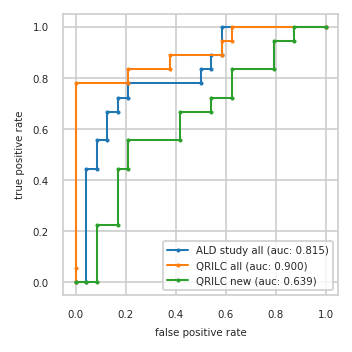

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.042 0.000
2          0.042 0.444     0.000 0.778     0.083 0.000
3          0.083 0.444     0.208 0.778     0.083 0.222
4          0.083 0.556     0.208 0.833     0.167 0.222
5          0.125 0.556     0.375 0.833     0.167 0.444
6          0.125 0.667     0.375 0.889     0.208 0.444
7          0.167 0.667     0.583 0.889     0.208 0.556
8          0.167 0.722     0.583 0.944     0.417 0.556
9          0.208 0.722     0.625 0.944     0.417 0.667
10         0.208 0.778     0.625 1.000     0.542 0.667
11         0.500 0.778     1.000 1.000     0.542 0.722
12         0.500 0.833       NaN   NaN     0.625 0.722
13         0.542 0.833       NaN   NaN     0.625 0.833
14         0.542 0.889       NaN   NaN     0.792 0.833
15         0.583 0.889       NaN   NaN     0.792 0.944
16         0.583 1.000       NaN   NaN     0.875 0.944
17         1.000 1.000       NaN   NaN     0.875 1.000
18           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,P15151-2,None
2,B1AHL2;P23142-4,Q15848,None
3,P61981,P61981,None
4,P14174,Q9Y2T3;Q9Y2T3-3,None
5,P04075,P14174,None
6,Q9Y2T3;Q9Y2T3-3,P04075,None
7,Q99983,P63104,None
8,P00338;P00338-3,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


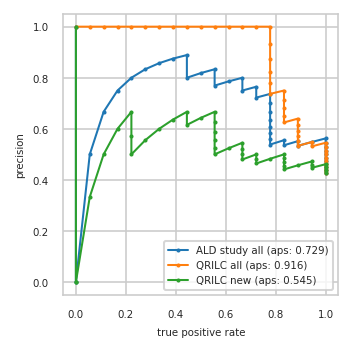

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.531 0.944     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.533 0.889     0.533 0.889     0.500 0.833
13         0.552 0.889     0.552 0.889     0.483 0.778
14         0.536 0.833     0.571 0.889     0.464 0.722
15         0.556 0.833     0.593 0.889     0.481 0.722
16         0.538 0.778     0.615 0.889     0.500 0.722
17         0.560 0.778     0.640 0.889     0.480 0.667
18         0.583 0.778     0.625 0.833     0.500 0.667
19         0.609 0.778     0.652 0.833     0.522 0.667
20         0.636 0.778     0.682 0.833     0.545 0.667
21         0.667 0.778     0.714 0.833     0.524 0.611
22         0.700 0.778     0.750 0.833     0.500 0.556
23         0.737 0.778     0.737 0.778     0.526 0.556
24         0.722 0.722     0.778 0.778     0.556 0.556
25         0.765 0.722     0.824 0.778     0.588 0.556
26         0.750 0.667     0.875 0.778     0.625 0.556
27         0.800 0.667     0.933 0.778     0.667 0.556
28         0.786 0.611     1.000 0.778     0.643 0.500
29         0.769 0.556     1.000 0.722     0.615 0.444
30         0.833 0.556     1.000 0.667     0.667 0.444
31         0.818 0.500     1.000 0.611     0.636 0.389
32         0.800 0.444     1.000 0.556     0.600 0.333
33         0.889 0.444     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


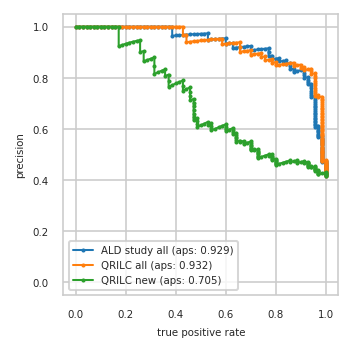

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


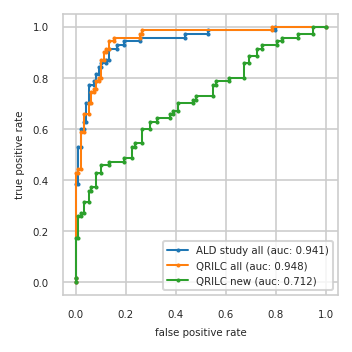

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}